## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback
from fastai.text.models import AWD_LSTM
import pandas as pd
import pickle
import os
import random
from shutil import copyfile
from tqdm import tqdm_notebook as tqdm

In [5]:
pickle_in = open("data/pickles/vocab.pickle","rb")
vocab = pickle.load(pickle_in)

In [10]:
print(len(vocab.itos))
print(vocab.itos[:10])

60004
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', '.']


## Preparing the data for pre-training the Language Model

In [4]:
path = Path('data/') # saves the location of all data
path.ls() # shows folders in path

[WindowsPath('data/all_data'),
 WindowsPath('data/models'),
 WindowsPath('data/pickles'),
 WindowsPath('data/test'),
 WindowsPath('data/train_all'),
 WindowsPath('data/unsup'),
 WindowsPath('data/urls.txt')]

In [12]:
bs=3 # GPUs with more CUDA memory can learn faster with a larger batch size.

The data to improve the Wikipedia-trained LM (language model) is taken from 3 sources: the training data, the testing data and the unlabeled data. A randomly chosen 10% of this union is used as a validation set. For the 110kDBRD dataset, this amounts to 10,000 reviews in the validation set.

In [13]:
lm_not_loaded_before = False 

if lm_not_loaded_before:
    data_lm = (TextList.from_folder("data/")
                .filter_by_folder(include=['train_all', 'test', 'unsup'])
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs))
    data_lm.save('all_data')
else:
    data_lm = load_data(path, 'all_data', bs=bs)

We can have a look at what the data looks like.

In [7]:
data_lm.show_batch()

idx,text
0,iemand beval me dit boek van deze auteur aan als de beste thriller die hij ooit had gelezen nadat ik had aangegeven een andere boek van hem veel te somber en te zwart te hebben gevonden . xxmaj eerlijkheid gebied me te zeggen dat ik dit wederom een zeer deprimerend boek vond . xxmaj het hoofdpersonage kent alleen maar pech en narigheid in zijn leven . xxmaj het is een
1,"het een uitdaging xxmaj anna 's verhaal te duiden en het verband tussen beide verhalen te achterhalen . xxmaj het besef , dat hier de vinger gelegd wordt op een hardnekkig xxmaj surinaams probleem , laat mij als lezer verslagen achter . \n xxmaj hele recensie lezen ? xxmaj zie : https : / / mijnboekenkast.blogspot.com / 2018 / 09 / xxunk \n xxmaj we gaan xxmaj wil"
2,"xxmaj van kleine kinderen tot ze vertrekken als ze zestien jaar zijn . \n xxmaj ze zijn xxunk kunnen zichzelf niet xxunk en zijn \n voorbestemd om meerdere organen te doneren tot de dood erop volgt . \n xxmaj op ingehouden , subtiele wijze geschreven . \n xxmaj je komt er langzaam achter waar dit boek over gaat . \n xxmaj soms ' vlak '"


For the classifier portion later on, the vocabulary of this dataset needs to be reused. It is stored as a pickle file so it can be quickly and easily retrieved.

In [7]:
pickle_out = open("data/pickles/vocab.pickle","wb")
pickle.dump(data_lm.vocab,pickle_out)
pickle_out.close()

## Language model

The pre-trained Wikipedia corpus LM is called lm_best.
It was generated by Benjamin van der Burgh and downloaded from http://bit.ly/2trOhzq. The program looks for it in the path/models folder, together with the "itos.pkl" file.

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=['lm_best', 'itos'], drop_mult=0.3)
learn.save_encoder('wiki_enc')
learn.save('loadable_wiki')

The model can predict sentences to show its current level of language understanding.

In [15]:
learn.load('loadable_wiki');
TEXT = "Wat een"
N_WORDS = 40
N_SENTENCES = 4
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)))

Wat een kleine groep Nederlander ( Schone Energie ) heet , een Belgisch gebied , ligt bij de Nederlandse grens . Zo is er een specifiek Nederlandse kust ; de Hollandse Eilanden .

Wat een ander voorbeeld is van de Franse vermomde Brussel is de Belgische Gouden Eeuw , een van de eerste in de wereld van Belgische kunst . De Belgische beroemde beeldhouwer Jan

Wat een Midden - Nederlandse politicus uit de Tweede Wereldoorlog is , maar een rol speelt bij de Partij van de Arbeid . De piet Caraïben is een bondgenoot van Nederland in het

Wat een ander Nederlands schat is , onbekend . De Nederlandse Bloedwraak Stichting maakt dat een vrouw een kind op een maria - school kan pietsie of heeft gewerkt . Op de kaart was de begeleiding


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


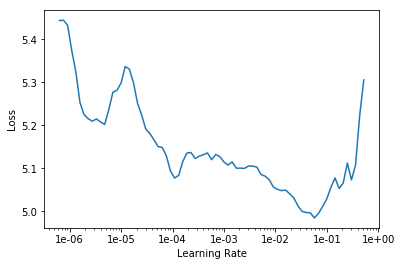

In [11]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

A good enough learning rate is about one order of magnitude smaller than lowest loss learning rate.
We start by fitting only the last layer (the 'head') of the Wikipedia-trained LM to the target-specific data.

In [13]:
head_fit_not_done_before = True

if head_fit_not_done_before:
    learn.freeze()
    learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) # With bs=3, this takes 7h15 on my machine.
    learn.save('fit_head')
    
else:
    learn.load('fit_head');

To start the real fine-tuning, the model is completely unfrozen so all the layers can change weights.

In [12]:
learn.unfreeze()

Improve the LM for 20 epochs. The model is saved every Xth epoch to 'bestmodel_X.pth'

In [ ]:
cb = SaveModelCallback(learn, every='epoch')
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7), callbacks=[cb]) # With bs=3, this takes 9h05 on my machine per epoch.

The model can predict sentences to show its current level of language understanding.
Due to an unwanted update-reboot, the program uses 'bestmodel_16' instead of 'bestmodel_19'. It takes my system a week to get to epoch 17, so a re-run was not considered worthwhile.

In [29]:
learn.load('bestmodel_16');
TEXT = "Wat een"
N_WORDS = 40
N_SENTENCES = 4
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)))

Wat een prachtig boek . Het verhaal is zo familie dat je er niet in moet komen maar het leest niet als een fantasy . Het is echt een me echt en feiten in de daarbij . 
 
  Het

Wat een prachtig verhaal . Je leeft mee met de vlot , met zal je weinig plot kan niets je je als lezer prettig in het verhaal wordt voeten . Ik heb volgt van de vriendinnen van de ben

Wat een 3 boek . Het leest als een fantasy en je vele de vaart en de krijg . 
  Met haar heel Anders en Het Geeft je een mooi vaak waar je je als lezer al

Wat een onderwerp weg ! 
  Het is een spannend verhaal ? een goed die op een dag wordt heel noemen en haar verhaal druk . De ouders van Rustige Ouders zijn school na hun dood raakt .


These sentences are more inspired by book reviews than Wikipedia-articles.

The encoder is saved for later use in the classifier portion of the experiment.

In [22]:
learn.save_encoder('fine_tuned_enc')

## Dataset Sizes

In order to test ULMFiT for multiple dataset sizes, random samples are made for all the chosen dataset sizes. Training a neural net is very training set-dependent, and using multiple random samples will give us some insight on the influence they have.

In [8]:
def create_sample(amount,poslist,neglist):
    ## This function will create a sample with "amount" examples, of which half are positive, half negative.
    ## It will save this sample in "data/train{amount}-{split}", for a number "split" that has not been used before.
    half_amount = amount // 2
    split = 0
    current_dir = f"data/train{amount}-{split}"
    chosen_pozzies  = random.sample(poslist,half_amount)
    chosen_neggies = random.sample(neglist,half_amount)
    while(True):
        try:
            os.mkdir(current_dir)
            break
        except FileExistsError:
            split += 1
            current_dir = f"data/train{amount}-{split}"
    os.mkdir(current_dir+"/pos")
    os.mkdir(current_dir+"/neg")
    for chosen_element in chosen_pozzies:
        copyfile("data/train_all/pos/"+chosen_element,current_dir+"/pos/"+chosen_element)
    for chosen_element in chosen_neggies:
        copyfile("data/train_all/neg/"+chosen_element,current_dir+"/neg/"+chosen_element)
    #print(f"Sample of {amount} elements made in folder {current_dir}.")

def create_samples(val_amount = 5, size_list = [50,100,150,200,500,1000,1500,2000,5000,10000,15000]):
    poslist = []
    neglist = []
    
    newposlist = []
    newneglist = []
    
    for filename in os.listdir("data/train_all/pos"):
        poslist.append(filename)
    
    for filename in os.listdir("data/train_all/neg"):
        neglist.append(filename)
        
    for sample_size in size_list:
        print(f"\nCreating {val_amount} samples of size {sample_size}")
        for validation_size in tqdm(range(val_amount)):
            try:
                create_sample(sample_size,poslist,neglist)
            except ValueError:
                print(f"Not enough data to make a sample of {sample_size}!")
                break

Below is an example of what the folder structure should look like after running the create_samples command.
Just moving the files instead of copying them and creating new folders would be faster and require no extra space.
Copying, however, allows for re-testing the same sample and checking for variability of results.

In [9]:
# create_samples(2,[50,150])
create_samples()

testpath = Path('data/')
testpath.ls()


Creating 5 samples of size 50




Creating 5 samples of size 100




Creating 5 samples of size 150




Creating 5 samples of size 200




Creating 5 samples of size 500




Creating 5 samples of size 1000




Creating 5 samples of size 1500




Creating 5 samples of size 2000




Creating 5 samples of size 5000




Creating 5 samples of size 10000




Creating 5 samples of size 15000


[WindowsPath('data/all_data'),
 WindowsPath('data/models'),
 WindowsPath('data/pickles'),
 WindowsPath('data/test'),
 WindowsPath('data/train100-0'),
 WindowsPath('data/train100-1'),
 WindowsPath('data/train100-2'),
 WindowsPath('data/train100-3'),
 WindowsPath('data/train100-4'),
 WindowsPath('data/train1000-0'),
 WindowsPath('data/train1000-1'),
 WindowsPath('data/train1000-2'),
 WindowsPath('data/train1000-3'),
 WindowsPath('data/train1000-4'),
 WindowsPath('data/train10000-0'),
 WindowsPath('data/train10000-1'),
 WindowsPath('data/train10000-2'),
 WindowsPath('data/train10000-3'),
 WindowsPath('data/train10000-4'),
 WindowsPath('data/train150-0'),
 WindowsPath('data/train150-1'),
 WindowsPath('data/train150-2'),
 WindowsPath('data/train150-3'),
 WindowsPath('data/train150-4'),
 WindowsPath('data/train1500-0'),
 WindowsPath('data/train1500-1'),
 WindowsPath('data/train1500-2'),
 WindowsPath('data/train1500-3'),
 WindowsPath('data/train1500-4'),
 WindowsPath('data/train15000-0'),
 Wi

## Classifier

Edit the values below to test another sample. If train_sample is set to True, be sure that a folder named "train{sample_size}-{current_validation}" was created in the previous step.

To train the classifier on the Wikipedia-trained LM directly (no fine-tuning), set fine_tuning to False

In [16]:
bs = 5 # GPUs with more CUDA memory can learn faster with a larger batch size.
train_sample = True
fine_tuning = False
sample_size = 50
current_validation = 0

In [17]:
#Load in the previously made vocabulary
pickle_in = open("data/pickles/vocab.pickle","rb")
data_lm_vocab = pickle.load(pickle_in)

In [49]:
# Rename the right folder to "train"
if train_sample:
    os.rename(f"data/train{sample_size}-{current_validation}",'data/train') # rename training folder to "train"
else:
    os.rename('data/train_all','data/train') # rename training folder to "train"

The following code performs the actual ULMFiT process!

In [50]:
#Load in the training and test folder
data_clas = (TextList.from_folder(path, vocab=data_lm_vocab)
             #grab all the text files in path, reuse vocab from data_lm
             .filter_by_folder(include=['train', 'test']) #f"train{dataset_size}-{current_validation}"
             #We may have other temp folders that contain text files so we only keep what's in train and test
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))
# data_clas.show_batch()

# Gradually unfreeze the top 3 layers and change the learning rate while doing so.
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
if fine_tuning:
    learn.load_encoder('fine_tuned_enc')
else:
    learn.load_encoder('wiki_enc')
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.680811,0.658182,0.661891,03:03


epoch,train_loss,valid_loss,accuracy,time
0,0.470030,0.614627,0.698185,03:03


epoch,train_loss,valid_loss,accuracy,time
0,0.316639,0.636122,0.579752,03:05


In [51]:
# Rename the "train" folder to its original name
if train_sample:
    os.rename('data/train',f"data/train{sample_size}-{current_validation}") # rename "train" folder
else:
    os.rename('data/train','data/train_all') # rename "train" folder

## Visualize results

The accuracy can be visualized in the Confusion matrix. The examples where the model considers itself to be worst, i.e. where the loss is the highest, can also be shown.

In [52]:
interp = learn.interpret()

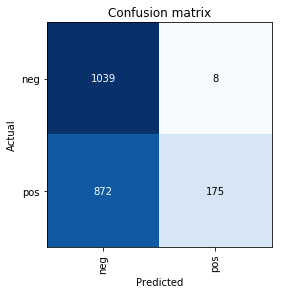

In [53]:
interp.plot_confusion_matrix()

In [54]:
interp.top_losses(k=5)

(tensor([1.9461, 1.7361, 1.7259, 1.6989, 1.6736]),
 tensor([1983, 2042, 1690, 1663, 1858]))

In [60]:
analyze_index = 2042

In [61]:
learn.data.valid_ds[analyze_index]

(Text xxbos xxmaj het xxmaj meesterwerk is goed geschreven , xxmaj de plot is misschien niet heel verrassend , maar is wel goed beschreven . xxmaj genieten van de eerste tot en met de laatste xxunk . xxmaj vanuit verschillende personen wordt het xxmaj meesterwerk belicht en het bevat verassende wendingen . 
   ' xxmaj het is autobiografisch , helemaal waargebeurd maar toch zie je elementen van fictie in de stijl en vooral de opbouw , dat maakt het des te sterker . ' - xxmaj win boeken voor je hele leesclub ! 
   xxmaj we gaan xxmaj wil van xxmaj jeroen xxmaj olyslaegers luisteren via de gratis xxmaj hebban xxmaj luisterboeken - app . xxmaj doe je mee ? 
   ' xxmaj wat beweegt de jonge zwarte deelpachter xxmaj tucker xxmaj caliban om huis , vee en akkers te vernietigen en met vrouw en kind naar het xxmaj noorden te vertrekken?'- xxmaj win xxmaj uit de maat voor je hele leesgroep !,
 Category pos)

In [57]:
y_probs, y_pred = learn.get_preds(ordered=True)

In [62]:
y_probs[analyze_index], y_pred[analyze_index] #tensor(0) is positive prediction, tensor(1) is negative

(tensor([0.6656, 0.3344]), tensor(1))